# Lab 4: Natural Language Inference with Attention Mechanism

In this lab session we will implement attention model for NLI based on  [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) initial model (non word-by-word). Although there are more complicated attention models (see for example the word-by-word attention model), it is interesting enough to understand how attentions work and how it is possible to implement with Keras.

For this we'll focus on a different NLP task: __Natural Language Inference__ (NLI). NLI consists in determining whether a natural language _hypothesis_ can justifiably be inferred from a natural language _premise_. Thus given a pair of  premise  and  hypothesis texts, the task is to classify them into three categories: _entailment_, _contradiction_, and _neutral_. The table below shows a few examples of premise/hypothesis along with the annotated labels (examples taken from [here](https://nlp.stanford.edu/pubs/snli_paper.pdf)).

The dataset we will use in this lab can be downloaded from [here](https://nlp.stanford.edu/projects/snli/) and it is a corpus comprised by The Stanford Natural Language Processing Group. Actually we are using a subset of the whole dataset. We'll give more details about the dataset in the next section.

| Premise                                                               | Category      | Hypothesis                                                         |
|:--------------------------------------------------------------------|:---------------|:--------------------------------------------------------------------|
| A man inspects the uniform of a figure in some East Asian country. | contradiction | The man is sleeping                                                |
| An older and younger man smiling.                                  | neutral       | Two men are smiling and laughing at the cats playing on the floor. |
| A black race car starts up in front of a crowd of people.          | contradiction | A man is driving down a lonely road.                               |
| A soccer game with multiple males playing.                         | entailment    | Some men are playing a sport.                                     |
| A smiling costumed woman is holding an umbrella.                   | neutral       | A happy woman in a fairy costume holds an umbrella.                |


## The Functional API
As you might note in order to predict the correct label we might need to be able to accept multiple independent inputs. The _Sequential_ class provided by Keras is not intentend to accept multiple inputs (it only accepts linear stacks of layers), and that's why we code the model using the _Functional API_ of Keras, which permits designing arbitrary DAG structures.
In the functional  API, we directly manipulate tensors. That is, we use layers like functions that take tensors as input and return tensors as output. You have further information [here](https://keras.io/models/model/), and you can find an example of a MLP model below.



## Attention Model
We will make some simplification to the model presented in [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) model. In our case, the conditional encoding of the sentences is obtained usin two different ```GRU``` layers. The premise is read by one ```GRU``` and the hypothesis sentence is read by the other GRU that learns different parameters. Two ```GRU``` layers are connected in a way that the second ```GRU``` is initialized with the last cell state of the premise GRU like shown in the example (the figure is taken from [Rocktäschel's](https://arxiv.org/pdf/1509.06664v4.pdf) paper).  

![image](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/main_arc.jpeg)

The paper proposes two attention models, we'll focus on the non word-by-word attention (Figure B), which is described in Section 2.3 of the paper. The model learns to capture important pieces of information of the premise based on the last output of the hypotesis (which contains the semantics of the hypothesis sentences). Please go through the paper to know about the mathematical details.


----
The main __objectives__ of this lab are the following:
 - Understant attention mechanism.
 - Learn to implement it in Keras.
 - Use the _functional API_ of Keras.
 - Implement architecture that accept multiple inputs.

In [1]:
# install libraries
!pip install tensorflow
!pip install datasets
# import load_dataset from dataset
from datasets import load_dataset
import pandas as pd
import tensorflow as tf

## Functional API Example
As explained above, when using the functional API we use layers as functions that take tensor and return tensor. The way we combine these operations defines the model that can be seen as a graph-like data structure. Once we define all tensor operation we set the input and output via the ```Model```.

In this simple example we will create MLP model that combine two ```Dense``` layers (we are not going to train as we are not loading the data, but feel free play with it).

In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense

input_tensor = Input(shape=(64,)) # we use Input() to create Keras tensor
hidden_tensor = Dense(32, activation='relu')(input_tensor) # first layer that return intermidiate hidden state
output_tensor = Dense(1, activation='sigmoid')(hidden_tensor) # second layer that performs softmax classification

model = Model(inputs=input_tensor, outputs=output_tensor) # create the model

# Same stuff as in Sequential
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,113 (8.25 KB)

 Trainable params: 2,113 (8.25 KB)

 Non-trainable params: 0 (0.00 B)

## 1. Load data
In a similar way as in previous labs, we'll first load the data and inspect it. The data will be loaded from HuggingFace with the next function```load_dataset("stanfordnlp/snli")``` (the data is the same the one that you can downloaded from [here](https://nlp.stanford.edu/projects/snli/) , but we get rid off stuff we do not need this lab).

The dataset consists of the following three divisions:
-  ```snli_1.0_train.tsv.bz2```
- ```snli_1.0_dev.tsv.bz2```
-  ```snli_1.0_test.tsv.bz2```

-----

It is good idea before we upload the data to make sure that GPUs are visible for the notebook.

In [3]:
## check that your notebook sees a GPU, otherwise it would take for ever.
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


-----
Now we are ready to mount our Drive files:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = load_dataset("stanfordnlp/snli")
data = data.filter(lambda example: example["label"] != -1)
training_set = pd.DataFrame(data['train'])
dev_set = pd.DataFrame(data['validation'])
test_set = pd.DataFrame(data['test'])

print('Training size: {}'.format(len(training_set)))
print('Dev size: {}'.format(len(dev_set)))
print('Test size: {}'.format(len(test_set)))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/412k [00:00<?, ?B/s]

plain_text/validation-00000-of-00001.par(…):   0%|          | 0.00/413k [00:00<?, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/19.6M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/550152 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/550152 [00:00<?, ? examples/s]

Training size: 549367
Dev size: 9842
Test size: 9824


In [6]:
training_set.head()

,premise,hypothesis,label
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0
3,Children smiling and waving at camera,They are smiling at their parents,1
4,Children smiling and waving at camera,There are children present,0


In [7]:
from tensorflow.keras import preprocessing

max_words = 10000
max_seq = 40

# prepare vocabulary
train_texts = list(training_set.premise) + list(training_set.hypothesis)

# Create a tokenize that takes the most common words
tokenizer = preprocessing.text.Tokenizer(num_words=max_words)

# Build the word index (dictionary)
tokenizer.fit_on_texts(train_texts) # Create word index using only training part
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 34341 unique tokens.


In [8]:
from tensorflow.keras.utils import to_categorical

# Get data as a lists of integers
train_premises = tokenizer.texts_to_sequences(training_set.premise)
train_hypotheses = tokenizer.texts_to_sequences(training_set.hypothesis)

dev_premises = tokenizer.texts_to_sequences(dev_set.premise)
dev_hypotheses = tokenizer.texts_to_sequences(dev_set.hypothesis)

test_premises = tokenizer.texts_to_sequences(test_set.premise)
test_hypotheses = tokenizer.texts_to_sequences(test_set.hypothesis)

# Padding data: Turn the lists of integers into a 2D integer tensor of shape `(samples, max_seq)`
x_train_premises = preprocessing.sequence.pad_sequences(train_premises, maxlen=max_seq)
x_train_hypotheses = preprocessing.sequence.pad_sequences(train_hypotheses, maxlen=max_seq)

x_dev_premises = preprocessing.sequence.pad_sequences(dev_premises, maxlen=max_seq)
x_dev_hypotheses = preprocessing.sequence.pad_sequences(dev_hypotheses, maxlen=max_seq)

x_test_premises = preprocessing.sequence.pad_sequences(test_premises, maxlen=max_seq)
x_test_hypotheses = preprocessing.sequence.pad_sequences(test_hypotheses, maxlen=max_seq)

# Getting labels
y_train = to_categorical(training_set.label)
y_dev = to_categorical(dev_set.label)
y_test = to_categorical(test_set.label)

print(y_train.shape)

(549367, 3)


## 2. Conditional Model with no Attention
Before we create a conditional model with attention, it is a good idea to build a baseline model that does not learn any kind of attention.

The baseline model concatenates two GRU layers in a way that the second one is initialize with the last state of the first one. This can be done very easily with Keras.

In [9]:
from tensorflow.keras import Model, mixed_precision
from tensorflow.keras.layers import Input, Embedding, GRU, Dense
tf.keras.utils.set_random_seed(2)

num_classes = 3
embedding_size = 50
hidden_size = 128

# Note that batch size might affect the performance of the trained model.
batch_size = 2048
epochs = 6 # this should be enough


# Define an input sequence of length max_seq (40).
premise_inputs = Input(shape=(max_seq,))
hypothesis_inputs = Input(shape=(max_seq,))

embedding_lookup = Embedding(max_words,
                             embedding_size,
                             input_length=max_seq,
                             name="embedding")

# We use same embeddings for premise and hypothesis sentences
embedded_premise = embedding_lookup(premise_inputs)
embedded_hypothesis = embedding_lookup(hypothesis_inputs)

# Define premise as a GRU layer. Then we the embedded premise tensor as input
# and get the last output of the GRU layer and hidden state of the GRU.
premise = GRU(hidden_size, return_state=True, name='premise_gru', reset_after=False)
premise_outputs, state_h = premise(embedded_premise)

# Do the same for the hypothesis, but using another GRU initialized
# by the last hidden state of the previous GRU layer.
hypothesis = GRU(hidden_size, name='hypothesis_gru', reset_after=False)
hypothesis_output = hypothesis(embedded_hypothesis, initial_state=state_h)

# Define the output layer that perfoms the classification based on
# the last output of the GRU layer.
classifier = Dense(num_classes, activation='softmax')
labels = classifier(hypothesis_output)

# Define the model that takes two inputs (premise and hypotesis input)
# and outputs labels.
model = Model(inputs=[premise_inputs, hypothesis_inputs], outputs=labels)


model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

model.fit([x_train_premises, x_train_hypotheses], y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([x_dev_premises, x_dev_hypotheses], y_dev))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 50)    │    500,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ premise_gru (GRU)   │ [(None, 128),     │     68,736 │ embedding[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hypothesis_gru      │ (None, 128)       │     68,736 │ embedding[1][0],  │
│ (GRU)               │                   │            │ premise_gru[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 3)         │        387 │ hypothesis_gru[0… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 637,859 (2.43 MB)

 Trainable params: 637,859 (2.43 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 26s 73ms/step - accuracy: 0.5520 - loss: 0.9327 - val_accuracy: 0.6459 - val_loss: 0.8006
Epoch 2/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6464 - loss: 0.7999 - val_accuracy: 0.6550 - val_loss: 0.7838
Epoch 3/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.6563 - loss: 0.7791 - val_accuracy: 0.6587 - val_loss: 0.7770
Epoch 4/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.6624 - loss: 0.7661 - val_accuracy: 0.6608 - val_loss: 0.7750
Epoch 5/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.6671 - loss: 0.7563 - val_accuracy: 0.6611 - val_loss: 0.7756
Epoch 6/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - accuracy: 0.6715 - loss: 0.7484 - val_accuracy: 0.6629 - val_loss: 0.7770


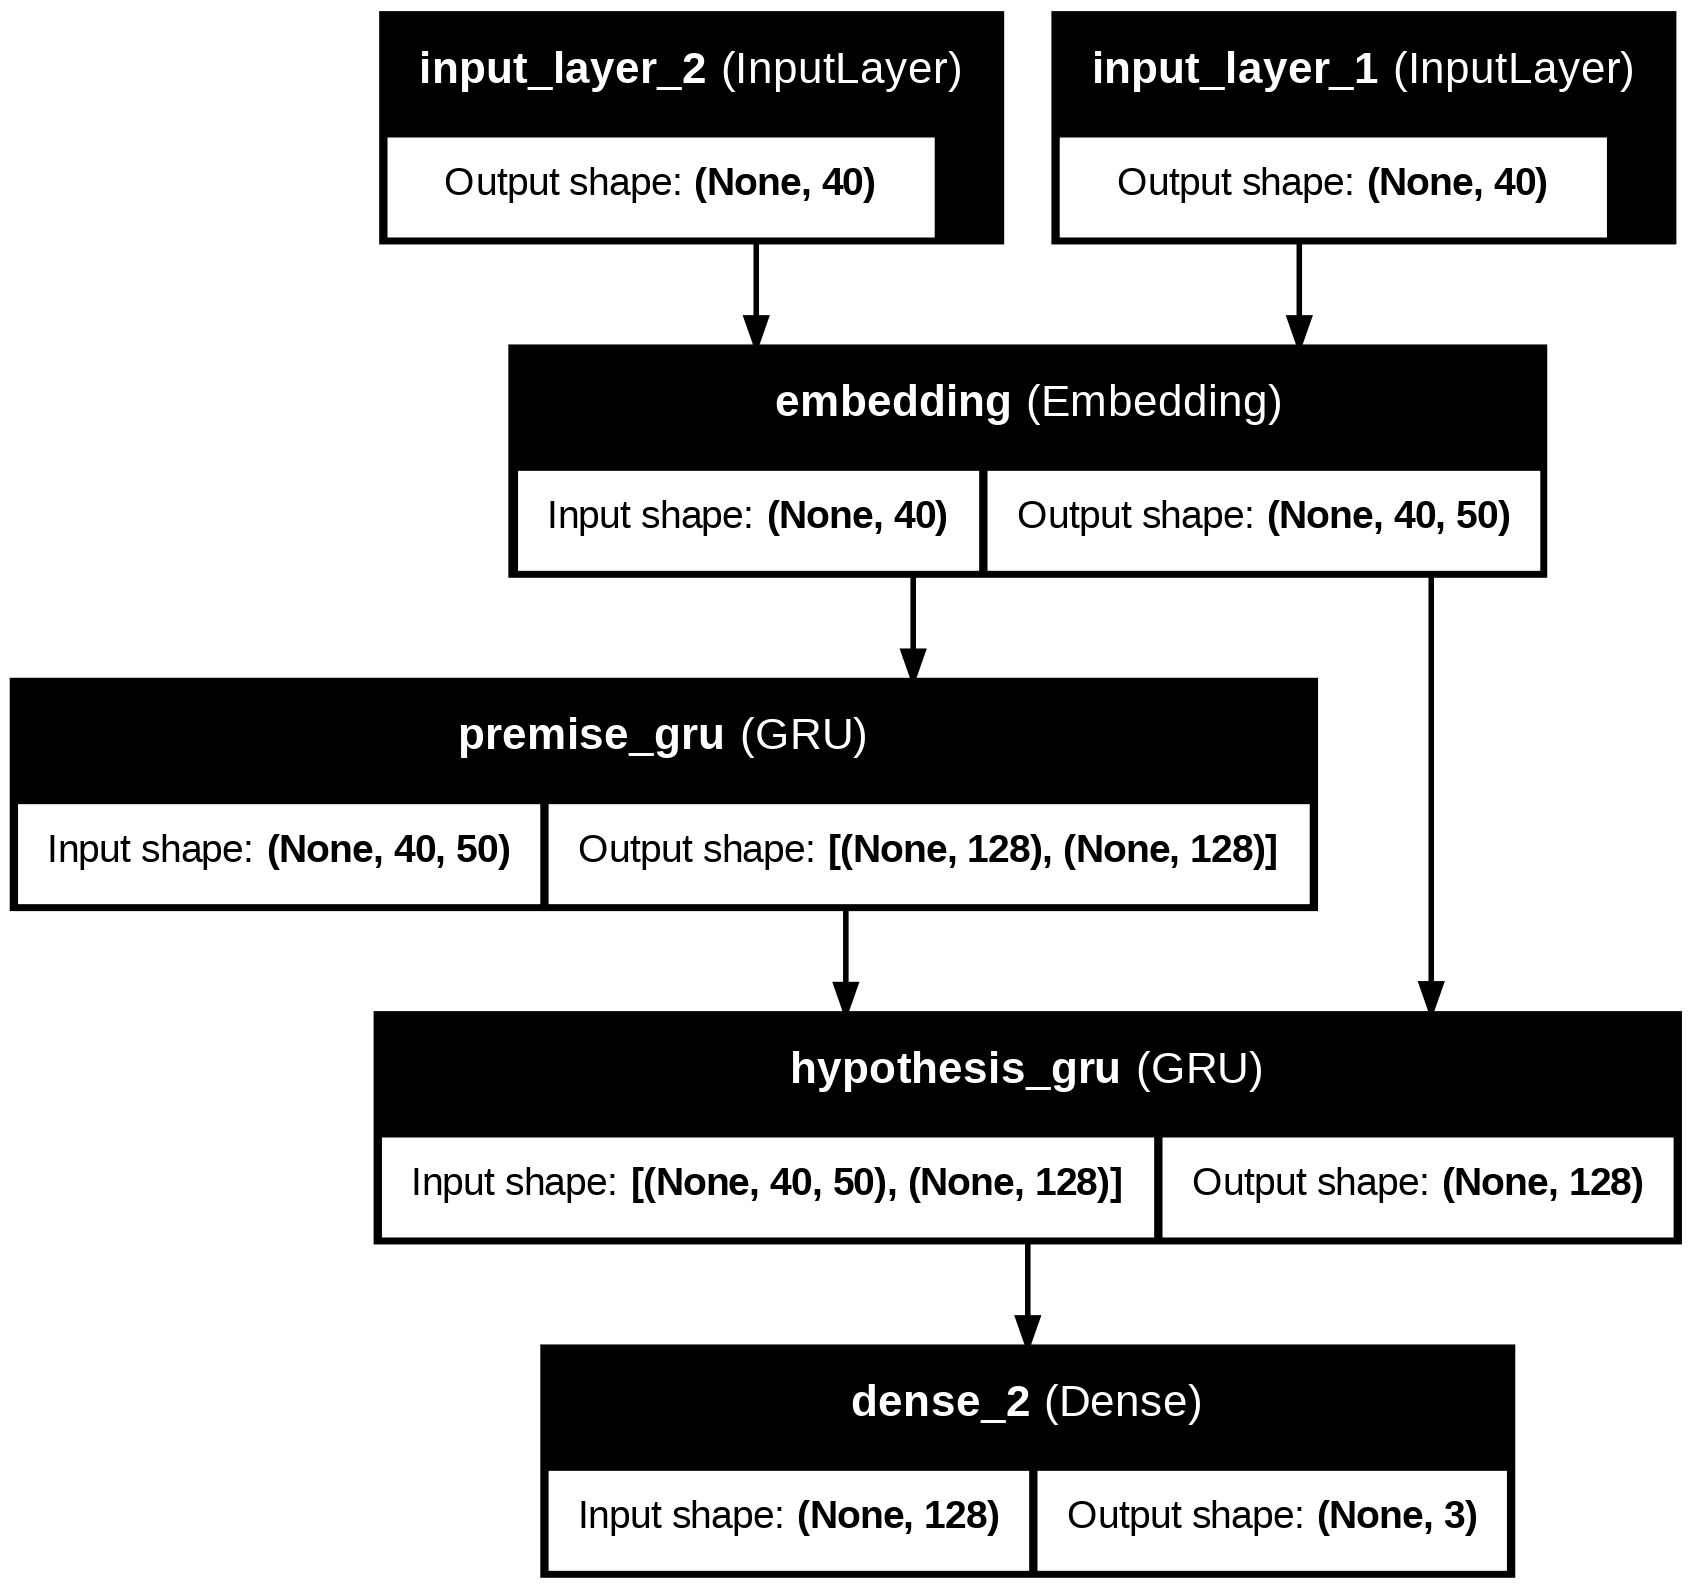

In [10]:
from tensorflow.keras.utils import plot_model

plot_model(model, 'model.png', show_shapes=True, show_layer_names=True)

As training takes a while, it may be a good idea to save the model for the future. (Ignore the warning message that trhows ```save_weights```  methods.)

In [11]:
# serialize model to JSON

model_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/models/'
model_json = model.to_json()
with open(model_home + 'snli-model-no_attention.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_home + 'snli-model-no_attention.weights.h5')

!ls drive/My\ Drive/Colab\ Notebooks/dl4nlp_summer_labs/models

snli-model-no_attention.json	    snli-model-with_attention.json
snli-model-no_attention.weights.h5  snli-model-with_attention.weights.h5


In [12]:
from tensorflow.keras.models import model_from_json

# load json and create model
model_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/models/'
json_file = open(model_home + 'snli-model-no_attention.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights(model_home + 'snli-model-no_attention.weights.h5')

print('Loaded model from disk')


Loaded model from disk


## 3. Conditional Model with Attention

The intuition behind the next attention mechanism is that once we read the whole hypothesis sentence and store its semantics in the last state ($\mathbf{h}_{N}$), the model looks back in the premise text to find some useful piece of information that updates the current semantics in state $\mathbf{h}_{N}$.

![image](http://ixa2.si.ehu.es/~jibloleo/uc3m_dl4nlp/img/snli_with_attention.png)

To learn attentions the paper proposes the following non-linear combinations:

 __Intermediate attention representation__:

> $\mathbf{M} = \tanh(\mathbf{W}^{y}\mathbf{Y} + \mathbf{W}^{h}\mathbf{h}_{N}\otimes \mathbf{e}_{L})$

> in which $\mathbf{W}^y, \mathbf{W}^ĥ \in \mathbb{R}^{k\times k}$ are trained projections matrices and $\mathbf{M} \in \mathbb{R}^{k \times L}$.   $\mathbf{e}_L \in \mathbb{R^L}$ is a vector of 1s, which its functions is to repeat $L$ times the vector obtained from  $\mathbf{W}^{h}\mathbf{h}_{N}$. $L$ is the length of the sequence, and $k$ the number of hidden units of the GRU layers.


 __Attention weights__:

> $\alpha = \text{softmax}(\mathbf{w}^T\mathbf{M}$)

> where $\mathbf{w} \in \mathbb{R}^k$ is a trained vector that parametrizes the attention given to each word in the premise, and produce a vector $\alpha \in \mathbb{R}^L$ of attention weights.

 __Attention results__:

> $\mathbf{r} = \mathbf{Y}\alpha^T$

> where $\mathbf{r} \in \mathbb{R}^k$ is the weighted representation of the premise text.



The final __sentence-pair representation__ is obtained from a non-linear combination of the attention weighted
representation $\mathbf{r}$ of the premise and the last output vector $\mathbf{h}_N$ using

> $\mathbf{h}^{*} = \tanh(\mathbf{W}^{p}\mathbf{r} + \mathbf{W}^{x}\mathbf{h}_N)$

> where  $\mathbf{h}* \in \mathbb{R}^k$ , and $\mathbf{W}^p$, $\mathbf{W}^x$ are trained projection matrices.

-----

### Exercise 1

This might look quite complicated at the begining, so take your time to understand the matrix operation and try to think how would you implement this using Keras layers.

- For example, how would you implement $\mathbf{W}^{y}\mathbf{Y}$ operation using Keras layers?

 `Dense` layers are appropiate to implement  $\mathbf{W}^{y}\mathbf{Y}$ . Note that the layer implementes the following operation `output = activation(dot(input, weights))`.

  Note that the data is comming in a different shape compared to the mathemathical notation ($\mathbf{W}^{y}\mathbf{Y} \in \mathbb{R}^{kxL}$ (where k is the embedding dimensionality and L is the sequence length). Data is comming as BatchSizeXSeqLengthxEmbDim, and this make natural to apply `Dense` layer to obtain equivalent output.


### Exercise 2

- Identify the implementation of each equation used for the attention.

```
# 1. Intermediate attention representation
W_y = Dense(hidden_size, activation='linear', use_bias=False, name='W_y')
h_premise = W_y(premise_outputs)

W_h = Dense(hidden_size, activation='linear', use_bias=False, name='W_h')
h_hypothesis_part = W_h(hypothesis_output)

h_hypothesis = RepeatVector(max_seq)(h_hypothesis_part)

added = Add()([h_premise, h_hypothesis])
M = Activation(activation='tanh', name='M')(added)

# 2. Attention weights
alpha_ = TimeDistributed(Dense(1, activation='linear', use_bias=False), name="alpha_")(M)
flat_alpha = Flatten(name="flat_alpha")(alpha_)
alpha = Activation(activation='softmax', name="alpha")(flat_alpha)

# 3. Attention result
r = Dot(axes=1, name='r')([premise_outputs, alpha])

# 4. Sentence pair representation
W_r = Dense(hidden_size, activation='linear', use_bias=False, name='W_r')(r)
W_x = Dense(hidden_size, activation='linear', use_bias=False, name='W_x')(hypothesis_output)
merged = Add()([W_r, W_x])
h_star = Activation('tanh', name='h_star')(merged)
```

---------------------------------------

In [13]:
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Activation, Add
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dot, Flatten

# Model size parameters
num_classes = 3
embedding_size = 50
hidden_size = 128

# Note that batch size might affect the performance of the trained model.
batch_size = 2048
epochs = 6 # This should be enough to see the differences in performance with a
           # simple model.

# Define an input sequence of length max_seq
premise_inputs = Input(shape=(max_seq,), name='premise_input')
hypothesis_inputs = Input(shape=(max_seq,), name='hypothesis_input')

embedding_lookup = Embedding(max_words,
                             embedding_size,
                             input_length=max_seq,
                             name="embedding")

# We use same embeddings for premise and hypothesis sentences
embedded_premise = embedding_lookup(premise_inputs)
embedded_hypothesis = embedding_lookup(hypothesis_inputs)

# Define premise as a GRU layer. Then we the embedded premise tensor as input
# and get the all outputs of the GRU layer (one per input token) and a hidden
# state of the GRU (we will you this to initialize the next GRU).
premise = GRU(hidden_size, return_sequences=True, return_state=True, name='premise_gru', reset_after=False)
premise_outputs, state_h = premise(embedded_premise)

# Process the hypothesis using the last hidden state of the premise,
# and obtain the last output of the GRU
hypothesis = GRU(hidden_size, name='hypotesis_gru', reset_after=False)
hypothesis_output = hypothesis(embedded_hypothesis, initial_state=state_h)


##                   ##
# Calculate attention #
##                   ##

# 1. Intermediate attention representation
W_y = Dense(hidden_size, activation='linear', use_bias=False, name='W_y')
h_premise = W_y(premise_outputs)

W_h = Dense(hidden_size, activation='linear', use_bias=False, name='W_h')
h_hypothesis_part = W_h(hypothesis_output)

h_hypothesis = RepeatVector(max_seq)(h_hypothesis_part)

added = Add()([h_premise, h_hypothesis])
M = Activation(activation='tanh', name='M')(added)

# 2. Attention weights
alpha_ = TimeDistributed(Dense(1, activation='linear', use_bias=False), name="alpha_")(M)
flat_alpha = Flatten(name="flat_alpha")(alpha_)
alpha = Activation(activation='softmax', name="alpha")(flat_alpha)

# 3. Attention result
r = Dot(axes=1, name='r')([premise_outputs, alpha])

# 4. Sentence pair representation
W_r = Dense(hidden_size, activation='linear', use_bias=False, name='W_r')(r)
W_x = Dense(hidden_size, activation='linear', use_bias=False, name='W_x')(hypothesis_output)
merged = Add()([W_r, W_x])
h_star = Activation('tanh', name='h_star')(merged)

##                  ##
# End of calculation #
##                  ##


# Define the output layer that perfoms the classification based on
# the updated output of the GRU layer using attention
classifier = Dense(num_classes, activation='softmax', name='classifier')
labels = classifier(h_star)

# Define the model that takes two inputs (premise and hypotesis input)
# and outputs labels.
model = Model(inputs=[premise_inputs, hypothesis_inputs], outputs=labels)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ premise_input       │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 40, 50)    │    500,000 │ premise_input[0]… │
│ (Embedding)         │                   │            │ hypothesis_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hypothesis_input    │ (None, 40)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ premise_gru (GRU)   │ [(None, 40, 128), │     68,736 │ embedding[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hypotesis_gru (GRU) │ (None, 128)       │     68,736 │ embedding[1][0],  │
│                     │                   │            │ premise_gru[0][1] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_h (Dense)         │ (None, 128)       │     16,384 │ hypotesis_gru[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_y (Dense)         │ (None, 40, 128)   │     16,384 │ premise_gru[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 40, 128)   │          0 │ W_h[0][0]         │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 40, 128)   │          0 │ W_y[0][0],        │
│                     │                   │            │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ M (Activation)      │ (None, 40, 128)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alpha_              │ (None, 40, 1)     │        128 │ M[0][0]           │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flat_alpha          │ (None, 40)        │          0 │ alpha_[0][0]      │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ alpha (Activation)  │ (None, 40)        │          0 │ flat_alpha[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ r (Dot)             │ (None, 128)       │          0 │ premise_gru[0][0… │
│                     │                   │            │ alpha[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_r (Dense)         │ (None, 128)       │     16,384 │ r[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ W_x (Dense)         │ (None, 128)       │     16,384 │ hypotesis_gru[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 128)       │          0 │ W_r[0][0],        │
│                     │                   │            │ W_x[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ h_star (Activation) │ (None, 128)       │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classifier (Dense)  │ (None, 3)         │        387 │ h_star[0][0]      │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 703,523 (2.68 MB)

 Trainable params: 703,523 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
tf.keras.utils.set_random_seed(2)
history = model.fit([x_train_premises, x_train_hypotheses], y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([x_dev_premises, x_dev_hypotheses], y_dev))

Epoch 1/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step - accuracy: 0.5602 - loss: 0.9148 - val_accuracy: 0.6612 - val_loss: 0.7789
Epoch 2/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 70ms/step - accuracy: 0.6570 - loss: 0.7806 - val_accuracy: 0.6687 - val_loss: 0.7626
Epoch 3/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 19s 69ms/step - accuracy: 0.6698 - loss: 0.7545 - val_accuracy: 0.6784 - val_loss: 0.7374
Epoch 4/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.6864 - loss: 0.7195 - val_accuracy: 0.6973 - val_loss: 0.7093
Epoch 5/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.7059 - loss: 0.6885 - val_accuracy: 0.7074 - val_loss: 0.6918
Epoch 6/6
269/269 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - accuracy: 0.7194 - loss: 0.6651 - val_accuracy: 0.7129 - val_loss: 0.6824


You can save the model as before.

In [15]:
# serialize model to JSON

model_home = 'drive/My Drive/Colab Notebooks/dl4nlp_summer_labs/models/'
model_json = model.to_json()
with open(model_home + 'snli-model-with_attention.json', 'w') as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights(model_home + 'snli-model-with_attention.weights.h5')


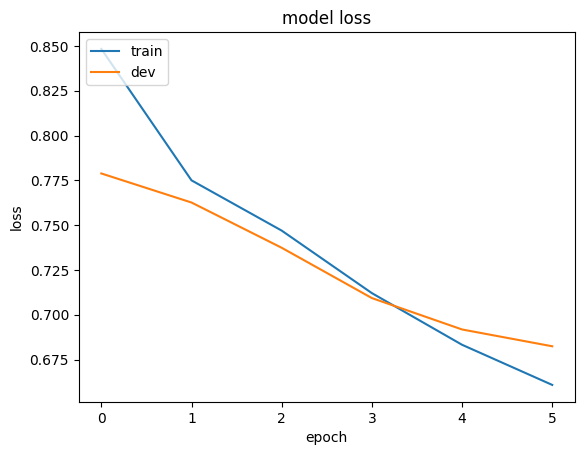

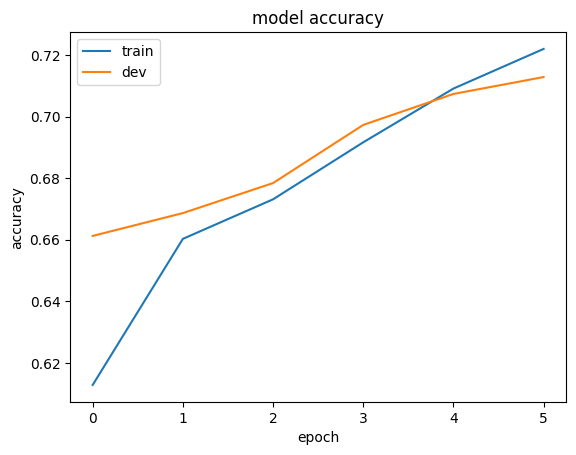

In [17]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

# score = model.evaluate(x_test, y_test, verbose=2)
# print("Accuracy: ", score[1])

## 4. Attention visualization

The attention model produces output vectors (the attention weights) summarizing contextual information of the premise that is useful to attend over later when reading the hypothesis.

Ploting attention weight can be useful in that it shows to what extent the attentive model focuses on contextual representations of the premise after both GRUs processed the premise and hypothesis respectively. This kind of qualitative analysis helps understanding the model.

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

inv_word_index = ['PAD']
for word in sorted(word_index, key=word_index.get):
    inv_word_index.append(word)

def get_attn(examples):
    layer_name = 'alpha'
    attention_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
    attn_weights = attention_layer_model.predict(examples)

    return np.reshape(attn_weights, [len(examples[0]), 40, 1])

def plot_attn(examples):
    attn_weights = get_attn(examples)

    for i in range(len(examples[0])):
        fig = plt.figure(figsize=(30, 10))
        ax = fig.add_subplot(111)
        ax.matshow(np.transpose(attn_weights[i,:,:]), vmin=0., vmax=1., cmap=plt.cm.Blues)
        premise_tokens = [inv_word_index[index] for index in examples[0][i]]
        hypothesis_tokens = [inv_word_index[index] for index in examples[1][i]  if inv_word_index[index] != 'PAD']

        plt.text(2, 1.5, 'H: ' + ' '.join(hypothesis_tokens), fontdict={'size':22})
        ax.set_xticklabels(premise_tokens, rotation=90)
        plt.xticks(np.arange(0, 40, 1.0), fontsize=16)
        plt.yticks(np.arange(0,1,1.0), fontsize=16)

### Exercise 3
The code below prints some visualizations for the given examples. Explore these examples and more, and see if you can identify any patterns in what the model has learned.

There is no clear pattern, but it looks like the following.
- Similar/same words get some attention (e.g. horse, skateboard, football).
- Category is neutral, it looks like the model does not know where to focus.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() 

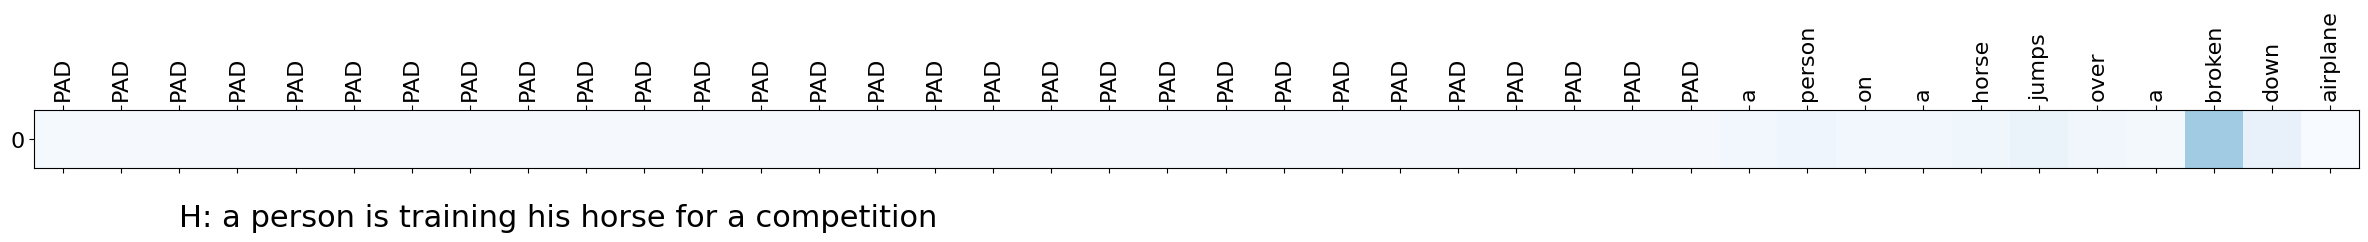

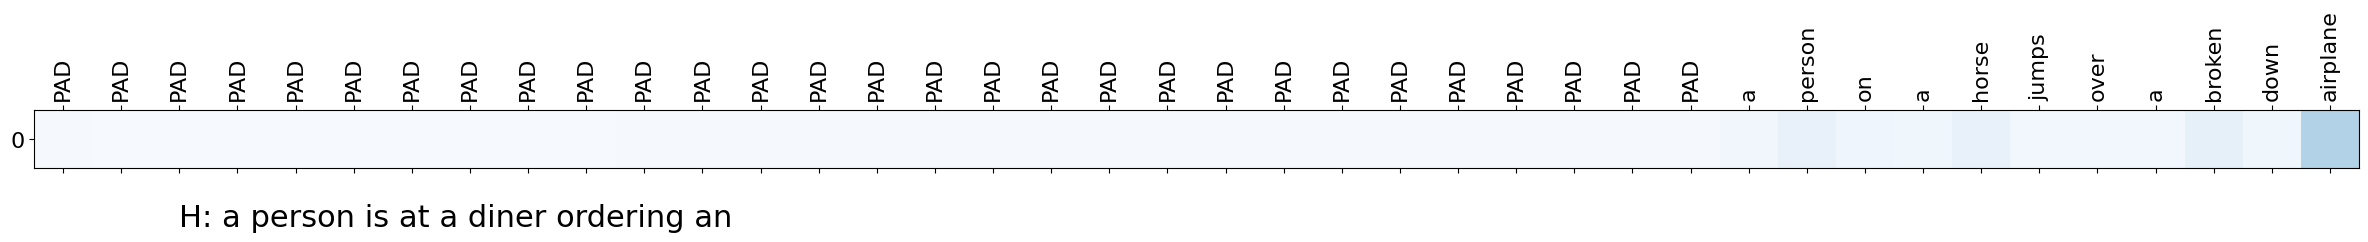

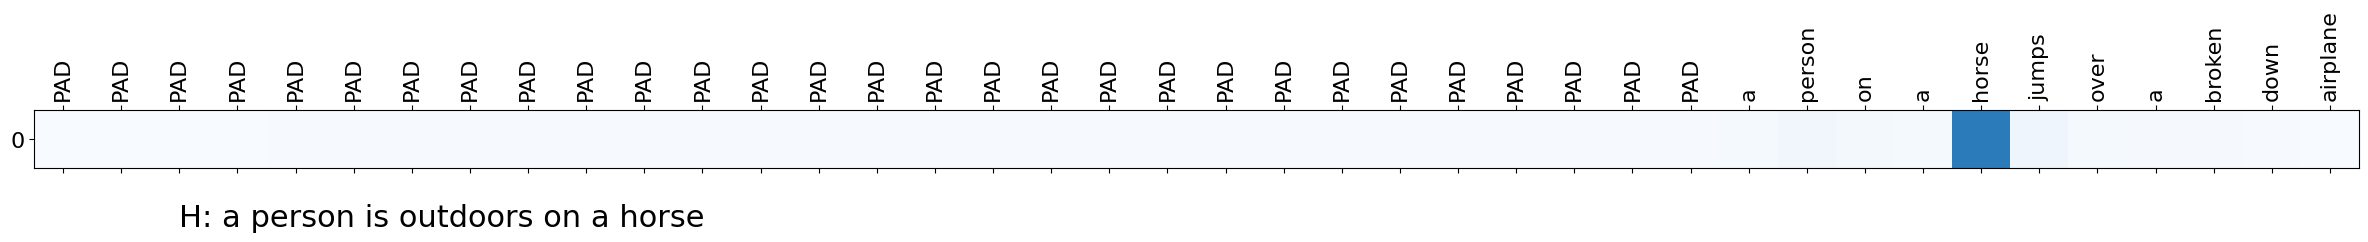

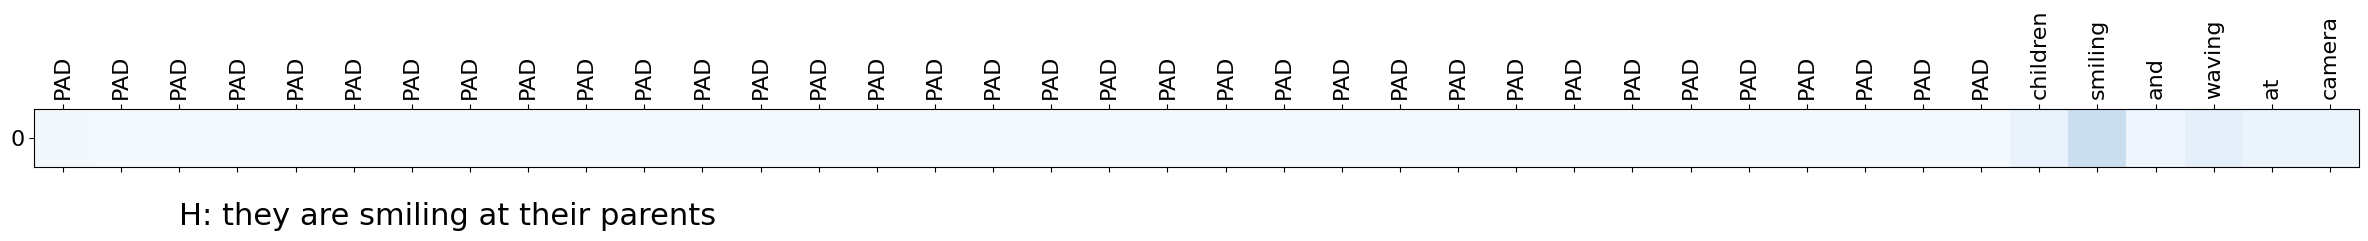

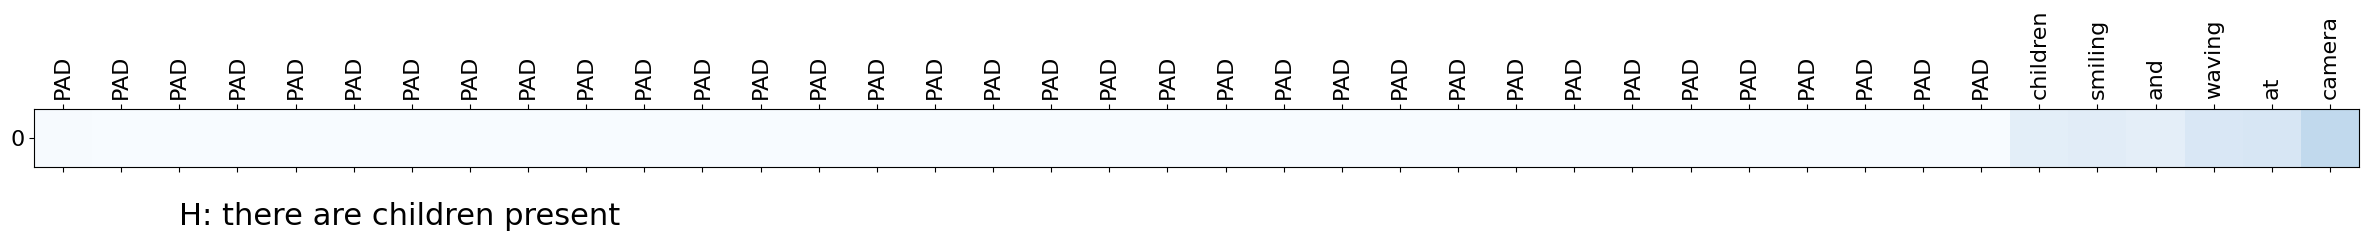

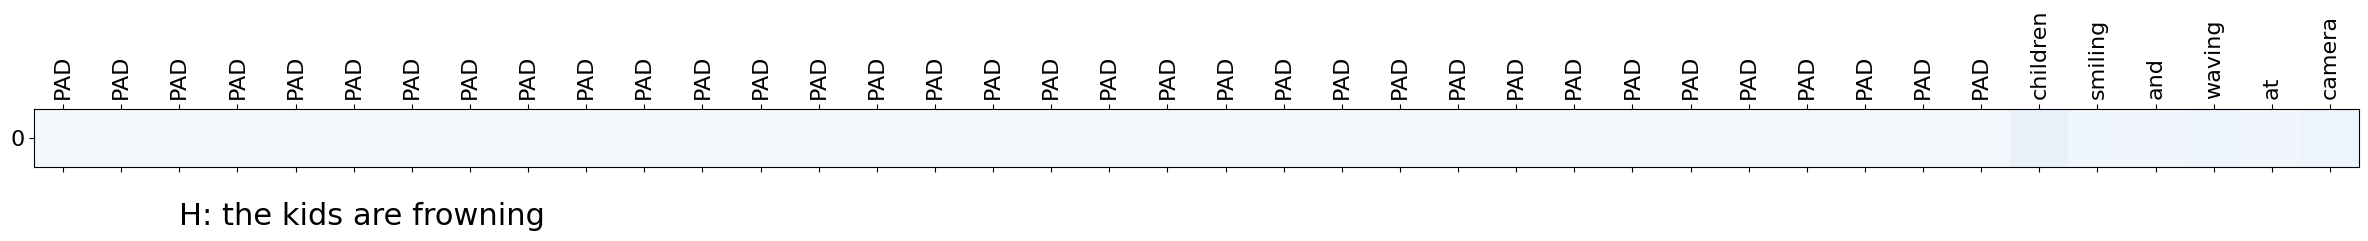

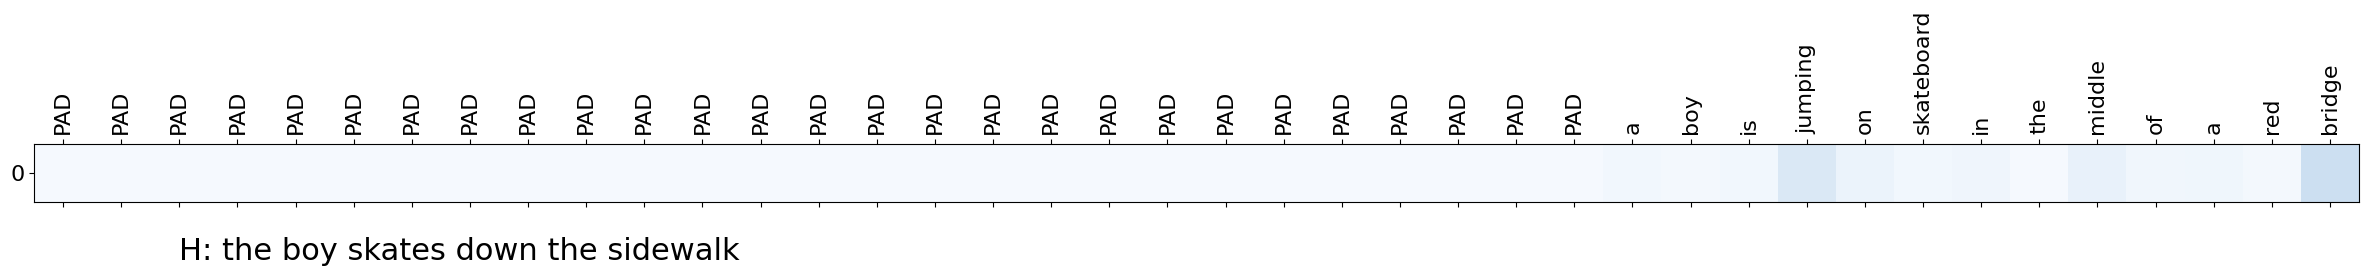

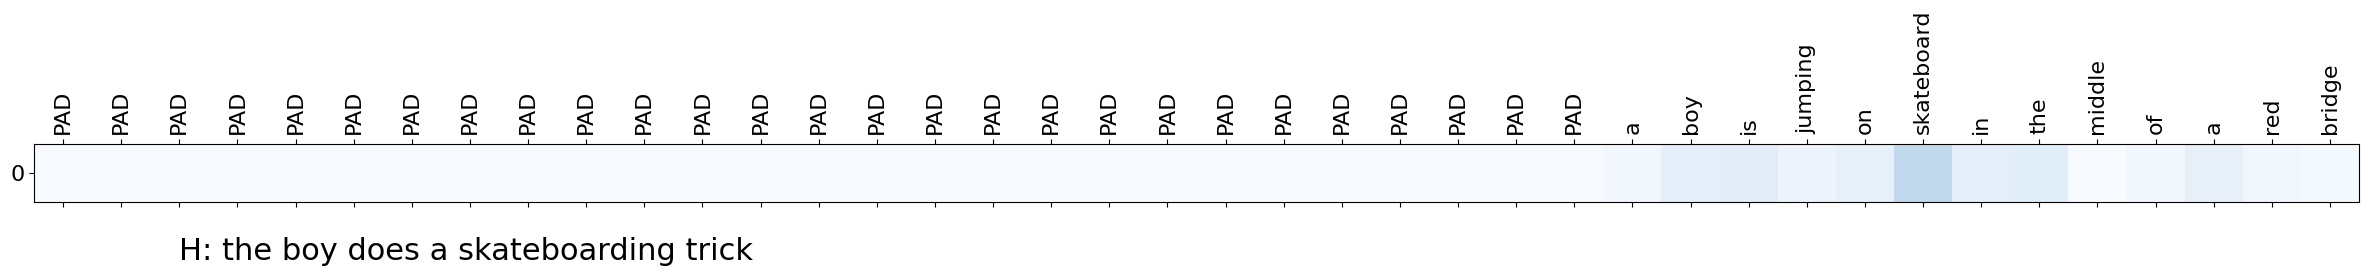

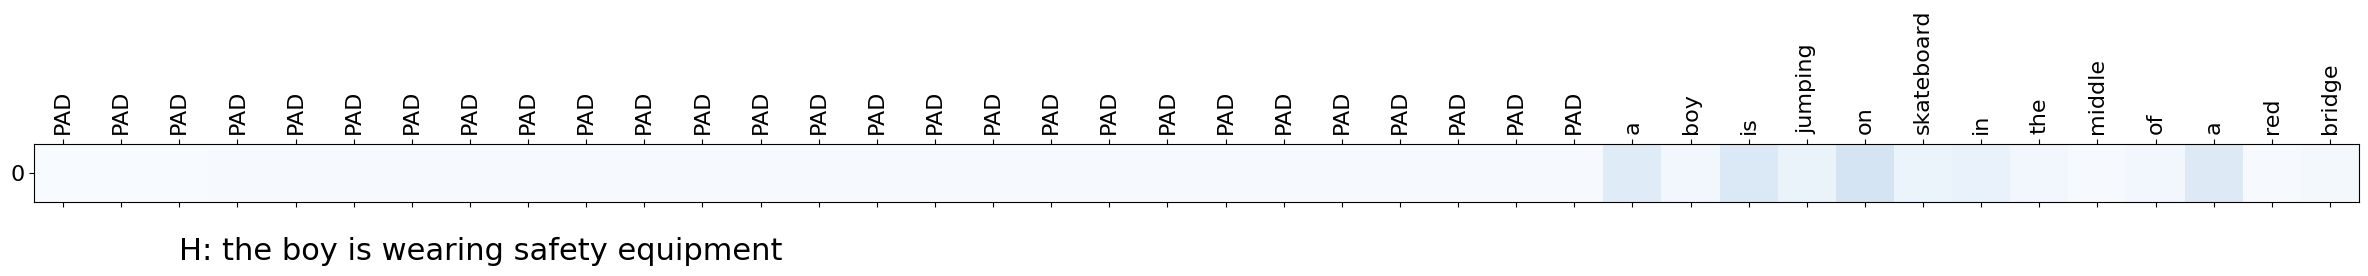

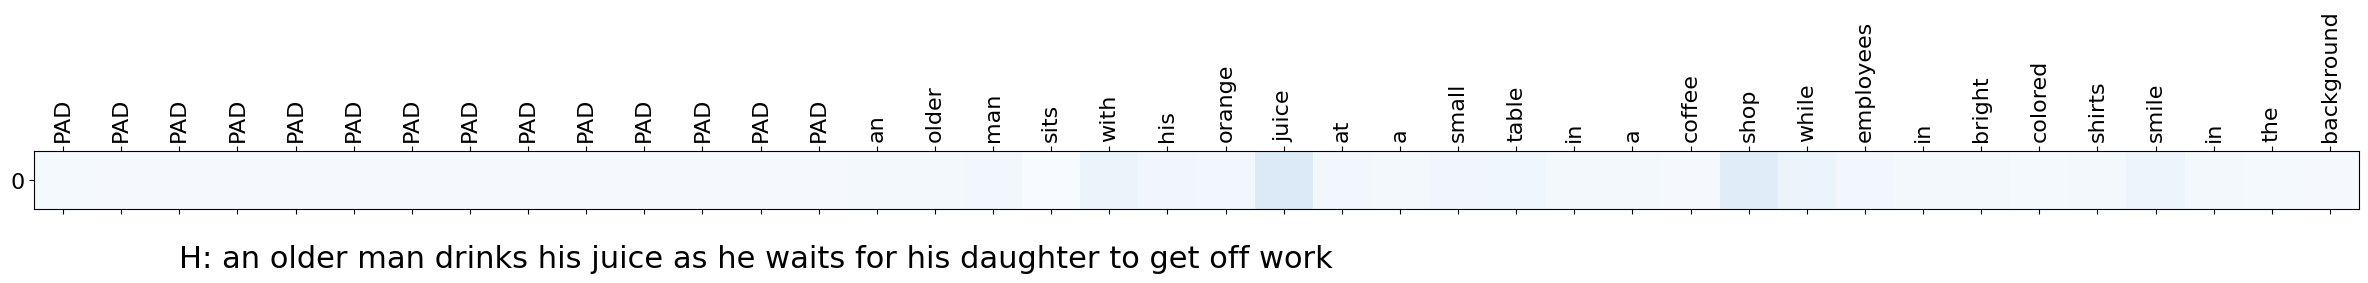

In [19]:
# Plot some attentions of the training examples.
examples = [x_train_premises[:10], x_train_hypotheses[:10]]
attn = plot_attn(examples)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(premise_tokens, rotation=90)
/tmp/ipython-input-3703639828.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() 

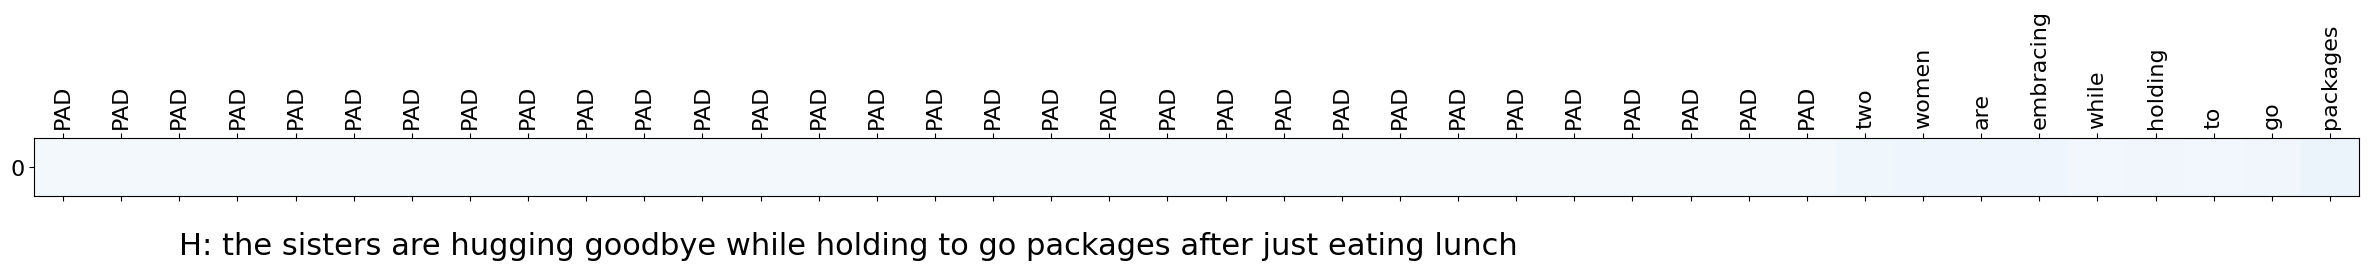

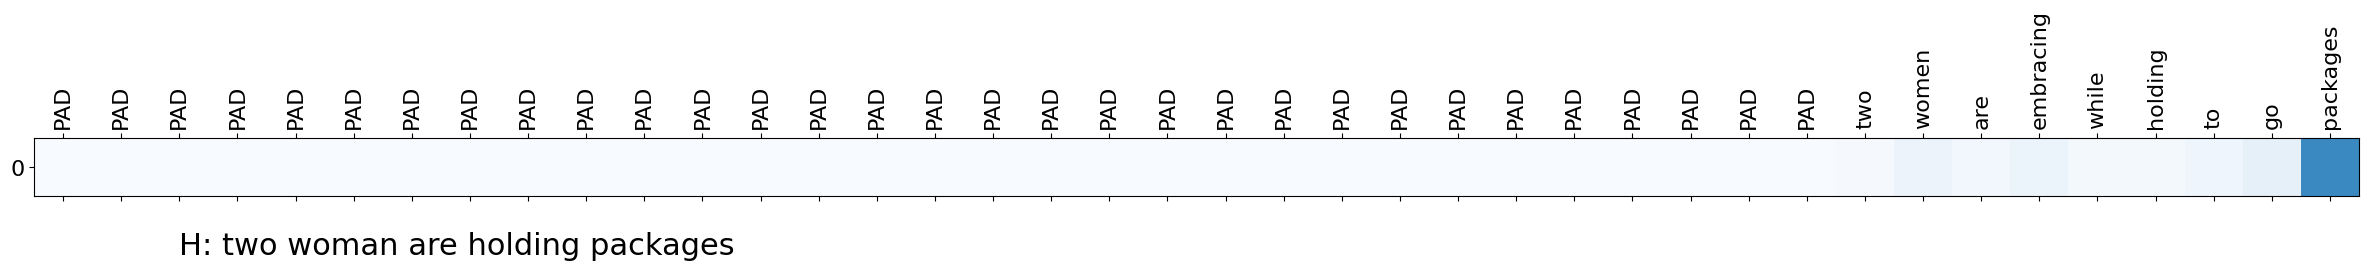

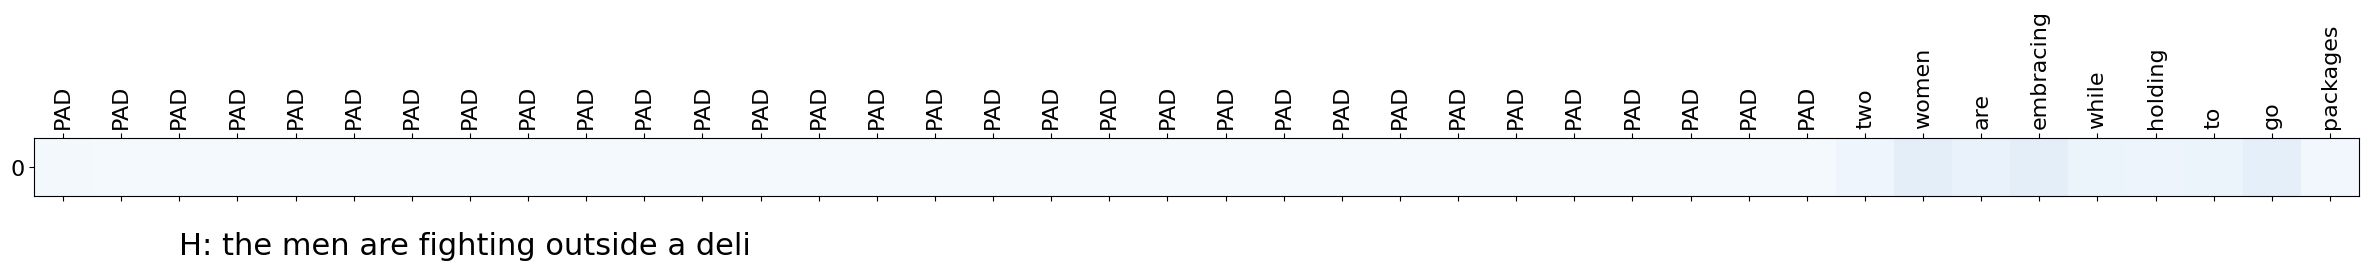

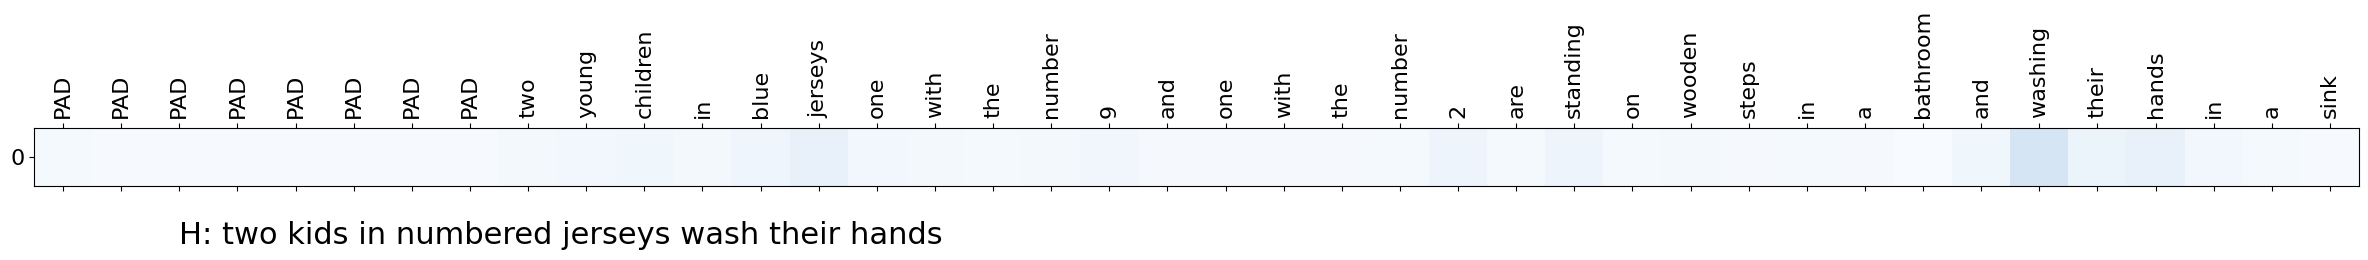

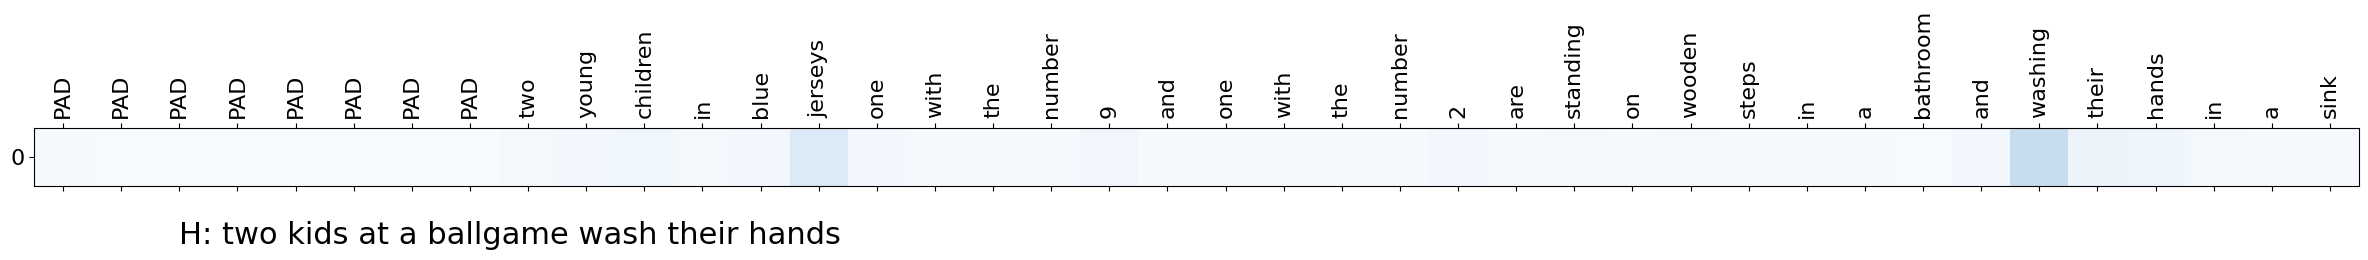

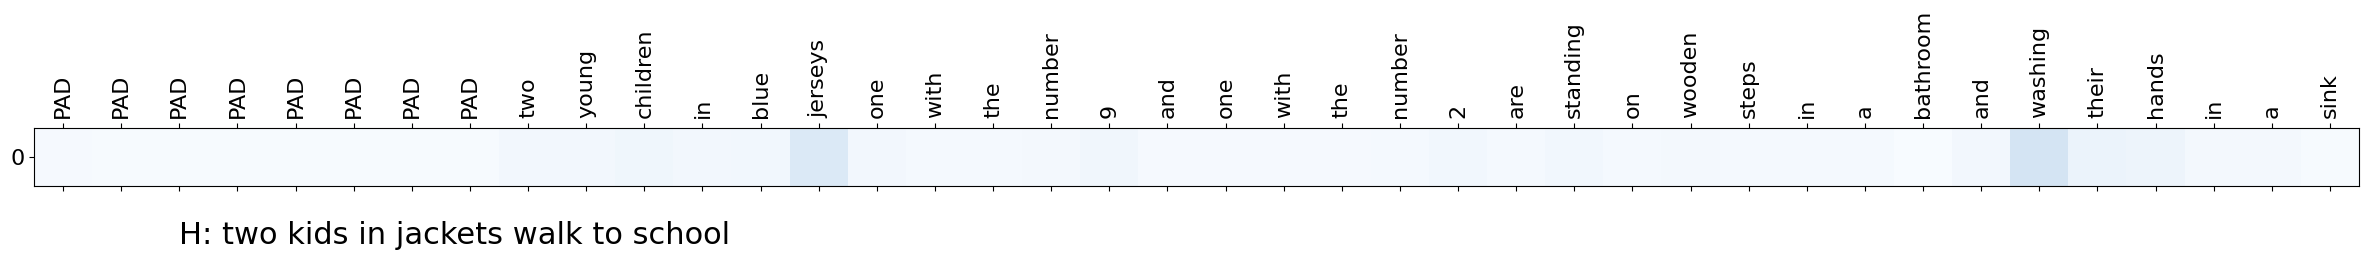

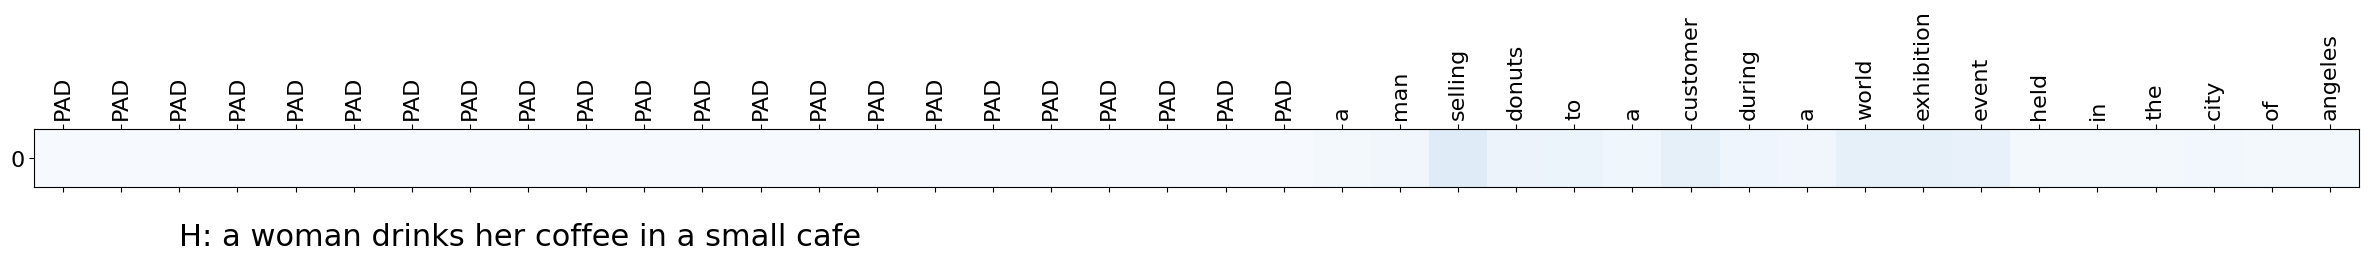

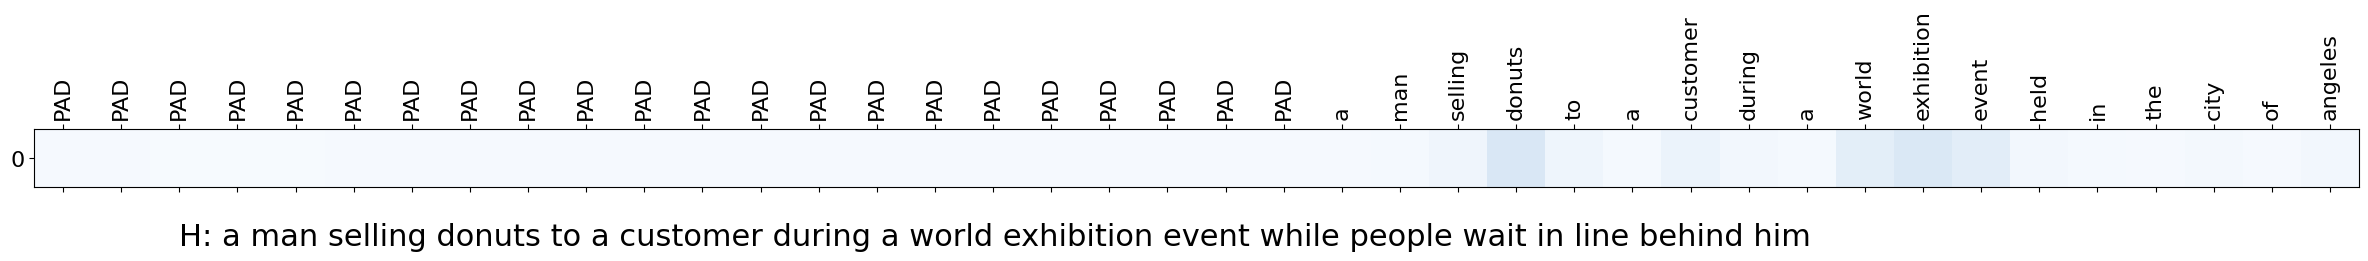

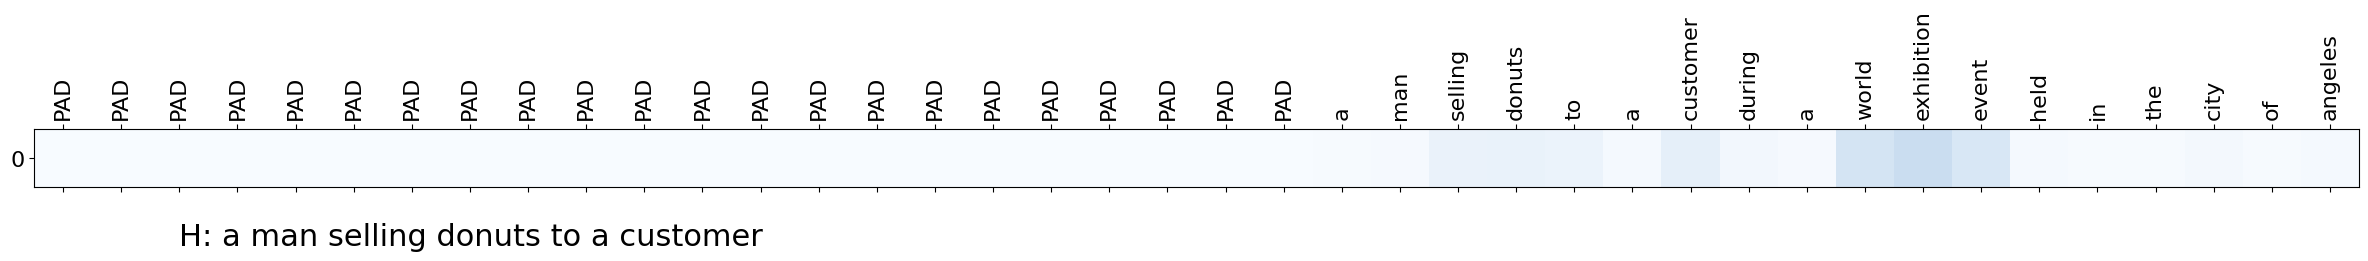

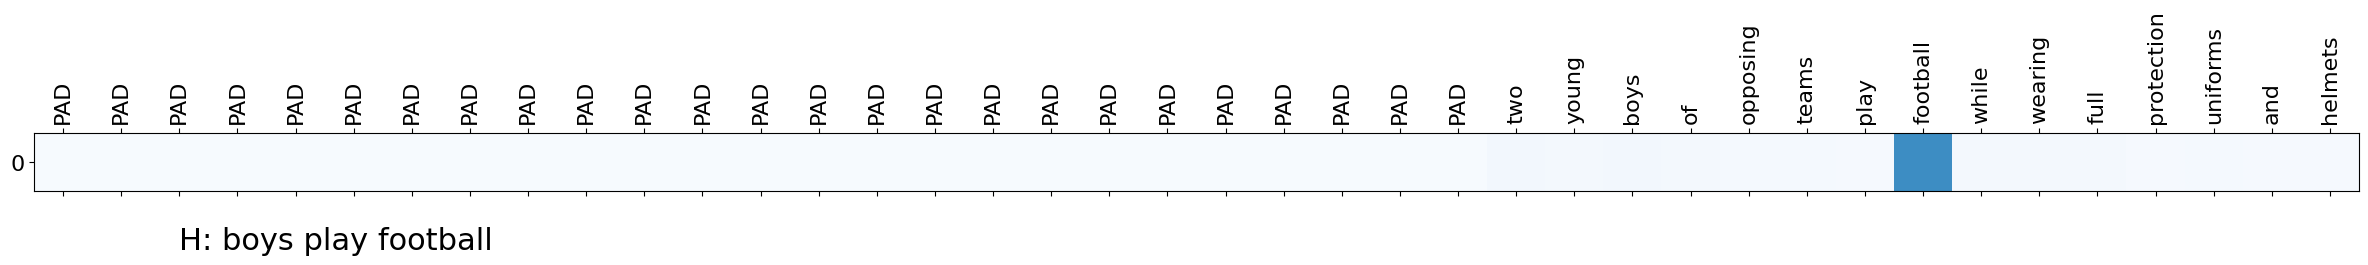

In [20]:
examples = [x_dev_premises[:10], x_dev_hypotheses[:10]]
attn = plot_attn(examples)


---

You can check how much GPU/CPU you are using in your colab sessions.

In [21]:
# memory footprint support libraries/code
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()

# XXX: only one GPU on Colab and isn't guaranteed
gpu = GPUs[0]

def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print('GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB'.format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7392 sha256=ff2ce29e203637c00b037083b53a08e5ade9479c1b57cde511eb0b85d7fa7e97
  Stored in directory: /root/.cache/pip/wheels/92/a8/b7/d8a067c31a74de9ca252bbe53dea5f896faabd25d55f541037
Successfully built gputil
Gen RAM Free: 10.2 GB  I Proc size: 2.7 GB
GPU RAM Free: 13676MB | Used: 1418MB | Util   9% | Total 15360MB
